# week4 授業課題 信用情報の学習

# このテキストについて
## テキストの目的
実データに近いものに対して機械学習を行う

## どのように学ぶか
Kaggleのデータセットを通じて、機械学習の基本的な流れやライブラリの使い方を学びます。

# 信用情報
Kaggleの Home Credit Default Risk コンペティションの学習および推定を行います。

Home Credit Default Risk | https://www.kaggle.com/c/home-credit-default-risk



In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# データ
train_data = pd.read_csv('C:/Users/miyas/kaggle/application_train.csv')
test_data = pd.read_csv('C:/Users/miyas/kaggle/application_test.csv')

In [3]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。

* 何を学習し、何を予測するのか　            
＞ 性別や学歴，雇用形態，自家用車所有の有無など122の特徴量から，住宅ローン債務者の返済する確率を予測する
        
* どのようなファイルを作りKaggleに提出するか                                
＞ SK_ID_CURRとTARGET（返済確率）の2列にしたcsvファイルを提出する                          
       
* 提出されたものはどういった指標値で評価されるのか                             
＞ AUC

# ベースラインモデルの作成
まずは単純な方法による **ベースラインモデル**　を作成します。精度の基準となるモデルです。

精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。
# 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。

検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。
# 【問題3】テストデータに対する推定
テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。

正しく提出が行えていれば、精度は低くても構いません。

## 前処理
### 欠損値の処理
今回は欠損のある列は削除する

In [4]:
# trainとtestを結合して，欠損値処理
train_data['train_test_FLG'] = 0
test_data['train_test_FLG'] = 1
t_t = pd.concat([train_data,test_data])
t_t_drop = t_t.dropna(how='any',axis=1)

# trainとtestに戻す
train_data2 = t_t_drop[t_t_drop['train_test_FLG'] == 0].drop(['train_test_FLG','SK_ID_CURR'],axis=1)
test_data2 = t_t_drop[t_t_drop['train_test_FLG'] == 1].drop(['train_test_FLG','SK_ID_CURR'],axis=1)

# データ数の確認
print('元データ：',train_data.shape)
print('train:',train_data2.shape)
print('test:',test_data2.shape)

C:\Users\miyas\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


元データ： (307511, 123)
train: (307511, 53)
test: (48744, 53)


### object型の処理
* オブジェクト型でラベルが３個以上はダミー変数化.
* それ以下はエンコーディング

In [5]:
train_data2.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_CONTRACT_TYPE             2
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_INCOME_TYPE               8
ORGANIZATION_TYPE             58
WEEKDAY_APPR_PROCESS_START     7
dtype: int64

In [6]:
test_data2.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_CONTRACT_TYPE             2
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
NAME_INCOME_TYPE               7
ORGANIZATION_TYPE             58
WEEKDAY_APPR_PROCESS_START     7
dtype: int64

In [7]:
# ラベルエンコーダーをインスタンス化
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train_data2:
    if train_data2[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train_data2[col].unique())) <= 2:
            # Train on the training data
            le.fit(train_data2[col])
            # Transform both training and test_data2ing data
            train_data2[col] = le.transform(train_data2[col])
            test_data2[col] = le.transform(test_data2[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)
print('Training Features shape: ', train_data2.shape)
print('test_data2ing Features shape: ', test_data2.shape)

3 columns were label encoded.
Training Features shape:  (307511, 53)
test_data2ing Features shape:  (48744, 53)


In [8]:
# one-hotエンコーディング
train_data3 = pd.get_dummies(train_data2,drop_first=True)
test_data3 = pd.get_dummies(test_data2,drop_first=True)

print('Training Features shape: ', train_data3.shape)
print('Testing Features shape: ', test_data3.shape)

Training Features shape:  (307511, 132)
Testing Features shape:  (48744, 129)


In [9]:
# trainとtestの特徴量を合わせる
train_data3, test_data3 = train_data3.align(test_data3, join = 'inner', axis = 1)

# 目的変数をもとに戻す
train_data3['TARGET'] = train_data['TARGET']

print('Training Features shape: ', train_data3.shape)
print('Testing Features shape: ', test_data3.shape)

Training Features shape:  (307511, 130)
Testing Features shape:  (48744, 129)


### データ形成
説明変数と目的変数に分け，numpy配列に．trainとtest（検証用）に分ける

In [10]:
# 特徴量と目的変数に分ける
X = train_data3.drop('TARGET',axis=1).values
app_test = test_data3.values
y = train_data3['TARGET'].values

In [11]:
# トレーニングデータとテストデータに分ける
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

### 学習・推定・評価
ランダムフォレストをベースラインとする

In [12]:
rf = RandomForestClassifier(n_estimators=100,random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [13]:
y_pred = rf.predict(X_test)

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('accuracy_score:',accuracy_score(y_test,y_pred))
print('precision_score:',precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score:',recall_score(y_true=y_test, y_pred=y_pred))
print('F値:',f1_score(y_true=y_test, y_pred=y_pred))

accuracy_score: 0.9204370542198712
precision_score: 0.0
recall_score: 0.0
F値: 0.0


C:\Users\miyas\Anaconda3\envs\test\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\miyas\Anaconda3\envs\test\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


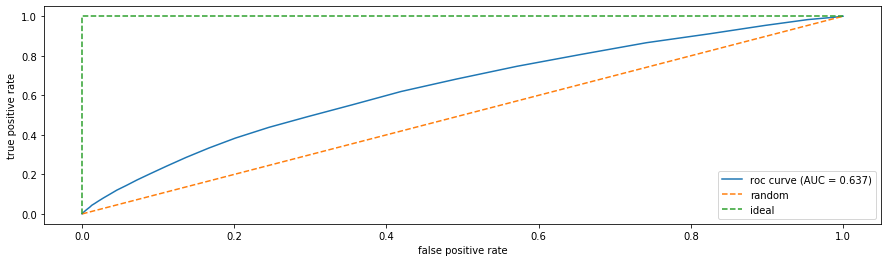

In [15]:
# AUCとROCを求める
from sklearn.metrics import roc_curve, auc

# テストデータが「１」に属する確率
score_y = rf.predict_proba(X_test)[:, 1]
# ROCを求める
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=score_y)

# 描画
plt.figure(figsize=(15,4))
plt.plot(fpr, tpr, label='roc curve (AUC = %0.3f)' % auc(fpr, tpr))
#あてずっぽうの場合の線
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
#AUCが１の場合の線
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')

plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

### 提出用ファイルの作成

In [16]:
test = test_data3.values
test_proba = rf.predict_proba(test)

In [17]:
rf.classes_

array([0, 1], dtype=int64)

In [18]:
test_proba1 = test_proba[:,1]

In [20]:
sub_df = test_data
sub_df.NAME_CONTRACT_TYPE = test_proba1
dropcol = sub_df.iloc[:,2:]
sub_df = sub_df.drop(dropcol,axis=1)
sub_df.columns = ['SK_ID_CURR','TARGET']
sub_df

,SK_ID_CURR,TARGET
0,100001,0.04
1,100005,0.04
2,100013,0.03
3,100028,0.09
4,100038,0.12
...,...,...
48739,456221,0.07
48740,456222,0.16
48741,456223,0.06
48742,456224,0.10


In [54]:
sub_df.to_csv('submit_baseline.csv',index=False)

Score 0.62773

# 特徴量エンジニアリング
ベースラインモデルを元に、入力する特徴量に様々な工夫を行い精度を向上させていきます。
# 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で **特徴量エンジニアリング（Feature Engineering）** を行ってください。

* どの特徴量を使うか
* どう前処理をするか
* 何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。

精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

## lightGBMで欠損処理もせず，object型の処理のみ行ってすべてを学習してみる

In [215]:
train_df = train_data
test_df = test_data

In [216]:
X_df = train_df.drop('TARGET',axis=1)
X_df['train_test_FLG'] = 0
test_df['train_test_FLG'] = 1
t_t = pd.concat([X_df,test_df])
t_t.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_test_FLG
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [217]:
# ラベルエンコーダー
le = LabelEncoder()
le_count = 0 
# Iterate through the columns
for col in t_t:
    if t_t[col].dtype == 'object':
        # ユニーク値が２以下のもののみ，ラベルエンコーディング
        if len(list(t_t[col].unique())) <= 2:
            le.fit(t_t[col])
            t_t[col] = le.transform(t_t[col])
            le_count += 1
            
print('%d columns were label encoded.' % le_count)
print('Features shape: ', t_t.shape)

2 columns were label encoded.
Features shape:  (356255, 122)


In [218]:
# one-hotエンコーディング
t_t = pd.get_dummies(t_t,drop_first=True)

print('Features shape: ', t_t.shape)

Features shape:  (356255, 273)


In [219]:
# trainとtestに戻す
X = t_t[t_t['train_test_FLG'] == 0].drop(['train_test_FLG','SK_ID_CURR'],axis=1).values
X_test = t_t[t_t['train_test_FLG'] == 1].drop(['train_test_FLG','SK_ID_CURR'],axis=1).values
y = train_df.TARGET.values

# データ数の確認
print('元データ：',train_df.shape)
print('X:',X.shape)
print('y:',y.shape)
print('test:',X_test.shape)

元データ： (307511, 123)
X: (307511, 271)
y: (307511,)
test: (48744, 271)


In [220]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state=1)

In [221]:
import lightgbm as lgb
#不均衡データなので，class_weight = 'balanced'にする
model = lgb.LGBMClassifier(objective='binary',class_weight='balanced')
model.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [222]:
def score_plot(model,X_val,y_val,y_pred):
    print('accuracy_score:',accuracy_score(y_test,y_pred))
    print('precision_score:',precision_score(y_true=y_test, y_pred=y_pred))
    print('recall_score:',recall_score(y_true=y_test, y_pred=y_pred))
    print('F値:',f1_score(y_true=y_test, y_pred=y_pred))
    # テストデータが「１」に属する確率
    score_y = model.predict_proba(X_val)[:, 1]
    # ROCを求める
    fpr, tpr, thresholds = roc_curve(y_true=y_val, y_score=score_y)

    # 描画
    plt.figure(figsize=(15,4))
    plt.plot(fpr, tpr, label='roc curve (AUC = %0.3f)' % auc(fpr, tpr))
    #あてずっぽうの場合の線
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    #AUCが１の場合の線
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')

    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

accuracy_score: 0.6518850131159625
precision_score: 0.07875675859489237
recall_score: 0.31553133514986376
F値: 0.12605110621275203


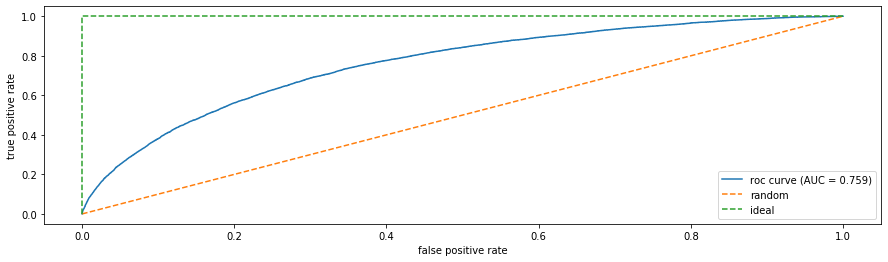

In [223]:
y_pred = model.predict(X_val)
score_plot(model,X_val,y_val,y_pred)

accuracy_score: 0.9183233247338869
precision_score: 0.07048458149779736
recall_score: 0.0021798365122615805
F値: 0.00422888859521607


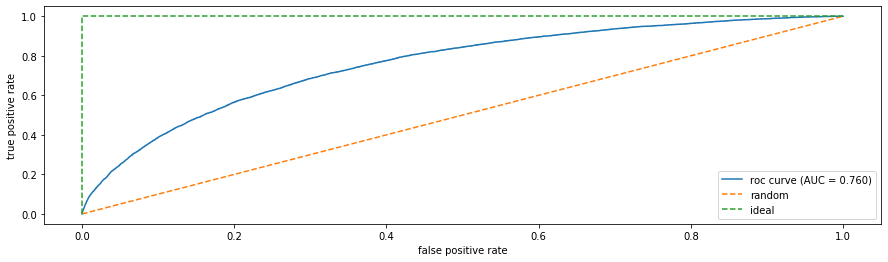

In [225]:
model1 = lgb.LGBMClassifier(objective='binary')
model1.fit(X_train,y_train)
y_pred1 = model1.predict(X_val)
score_plot(model1,X_val,y_val,y_pred1)

脱線だが意外だったので，メモ．不均衡だからclass_weightをbalancedにしてたけど，Noneの方がAUCが高い

In [227]:
model1.get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>

欠損値をすべて消すよりは，良さそう．
## 特徴量の重要度を見る

In [228]:
col = t_t.drop(['train_test_FLG','SK_ID_CURR'],axis=1).columns

In [231]:
f_importance = model.feature_importances_
f_importance_df = pd.DataFrame(f_importance,index=col,columns=['importance']).sort_values('importance', ascending = True)

In [232]:
pd.set_option('display.max_columns', None)#すべてのカラムを表示
f_importance_df.T

,NAME_CONTRACT_TYPE_0.3,NAME_CONTRACT_TYPE_0.26,NAME_CONTRACT_TYPE_0.27,NAME_CONTRACT_TYPE_0.28,NAME_CONTRACT_TYPE_0.29,WALLSMATERIAL_MODE_Wooden,NAME_CONTRACT_TYPE_0.31,NAME_CONTRACT_TYPE_0.32,NAME_CONTRACT_TYPE_0.33,NAME_CONTRACT_TYPE_0.34,NAME_CONTRACT_TYPE_0.25,NAME_CONTRACT_TYPE_0.35,NAME_CONTRACT_TYPE_0.37,NAME_CONTRACT_TYPE_0.38,NAME_CONTRACT_TYPE_0.39,NAME_CONTRACT_TYPE_0.4,NAME_CONTRACT_TYPE_0.41,NAME_CONTRACT_TYPE_0.44,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_XNA,NAME_TYPE_SUITE_Group of people,NAME_CONTRACT_TYPE_0.36,NAME_CONTRACT_TYPE_0.24,NAME_CONTRACT_TYPE_0.23,NAME_CONTRACT_TYPE_0.22,NAME_CONTRACT_TYPE_0.01,NAME_CONTRACT_TYPE_0.02,NAME_CONTRACT_TYPE_0.03,NAME_CONTRACT_TYPE_0.04,NAME_CONTRACT_TYPE_0.05,NAME_CONTRACT_TYPE_0.06,NAME_CONTRACT_TYPE_0.07,NAME_CONTRACT_TYPE_0.08,NAME_CONTRACT_TYPE_0.09,NAME_CONTRACT_TYPE_0.1,NAME_CONTRACT_TYPE_0.11,NAME_CONTRACT_TYPE_0.12,NAME_CONTRACT_TYPE_0.13,NAME_CONTRACT_TYPE_0.14,NAME_CONTRACT_TYPE_0.15,NAME_CONTRACT_TYPE_0.16,NAME_CONTRACT_TYPE_0.17,NAME_CONTRACT_TYPE_0.18,NAME_CONTRACT_TYPE_0.19,NAME_CONTRACT_TYPE_0.2,NAME_CONTRACT_TYPE_0.21,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Student,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,ORGANIZATION_TYPE_Industry: type 6,AMT_REQ_CREDIT_BUREAU_DAY,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 3,NAME_INCOME_TYPE_Unemployed,NAME_EDUCATION_TYPE_Incomplete higher,NAME_FAMILY_STATUS_Unknown,NAME_HOUSING_TYPE_Rented apartment,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 4,FLAG_DOCUMENT_21,EMERGENCYSTATE_MODE_Yes,FLAG_DOCUMENT_19,FLAG_DOCUMENT_7,ELEVATORS_MEDI,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,REG_REGION_NOT_LIVE_REGION,FLAG_DOCUMENT_12,FLAG_DOCUMENT_4,FLAG_DOCUMENT_20,FLAG_DOCUMENT_2,FLAG_DOCUMENT_17,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_CONT_MOBILE,WEEKDAY_APPR_PROCESS_START_TUESDAY,OCCUPATION_TYPE_Cleaning staff,NAME_HOUSING_TYPE_Municipal apartment,FLOORSMAX_MODE,YEARS_BUILD_MEDI,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Cleaning,OCCUPATION_TYPE_Managers,REG_REGION_NOT_WORK_REGION,ORGANIZATION_TYPE_Industry: type 11,LIVE_REGION_NOT_WORK_REGION,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 3,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,ORGANIZATION_TYPE_Electricity,FLOORSMAX_MEDI,FLAG_OWN_CAR,FLAG_DOCUMENT_8,FLAG_DOCUMENT_6,AMT_REQ_CREDIT_BUREAU_HOUR,NAME_FAMILY_STATUS_Single / not married,NAME_TYPE_SUITE_Unaccompanied,FLAG_PHONE,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Other,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Secretaries,WEEKDAY_APPR_PROCESS_START_SATURDAY,NAME_FAMILY_STATUS_Widow,CNT_FAM_MEMBERS,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Medicine staff,ORGANIZATION_TYPE_Hotel,NAME_TYPE_SUITE_Family

<BarContainer object of 80 artists>

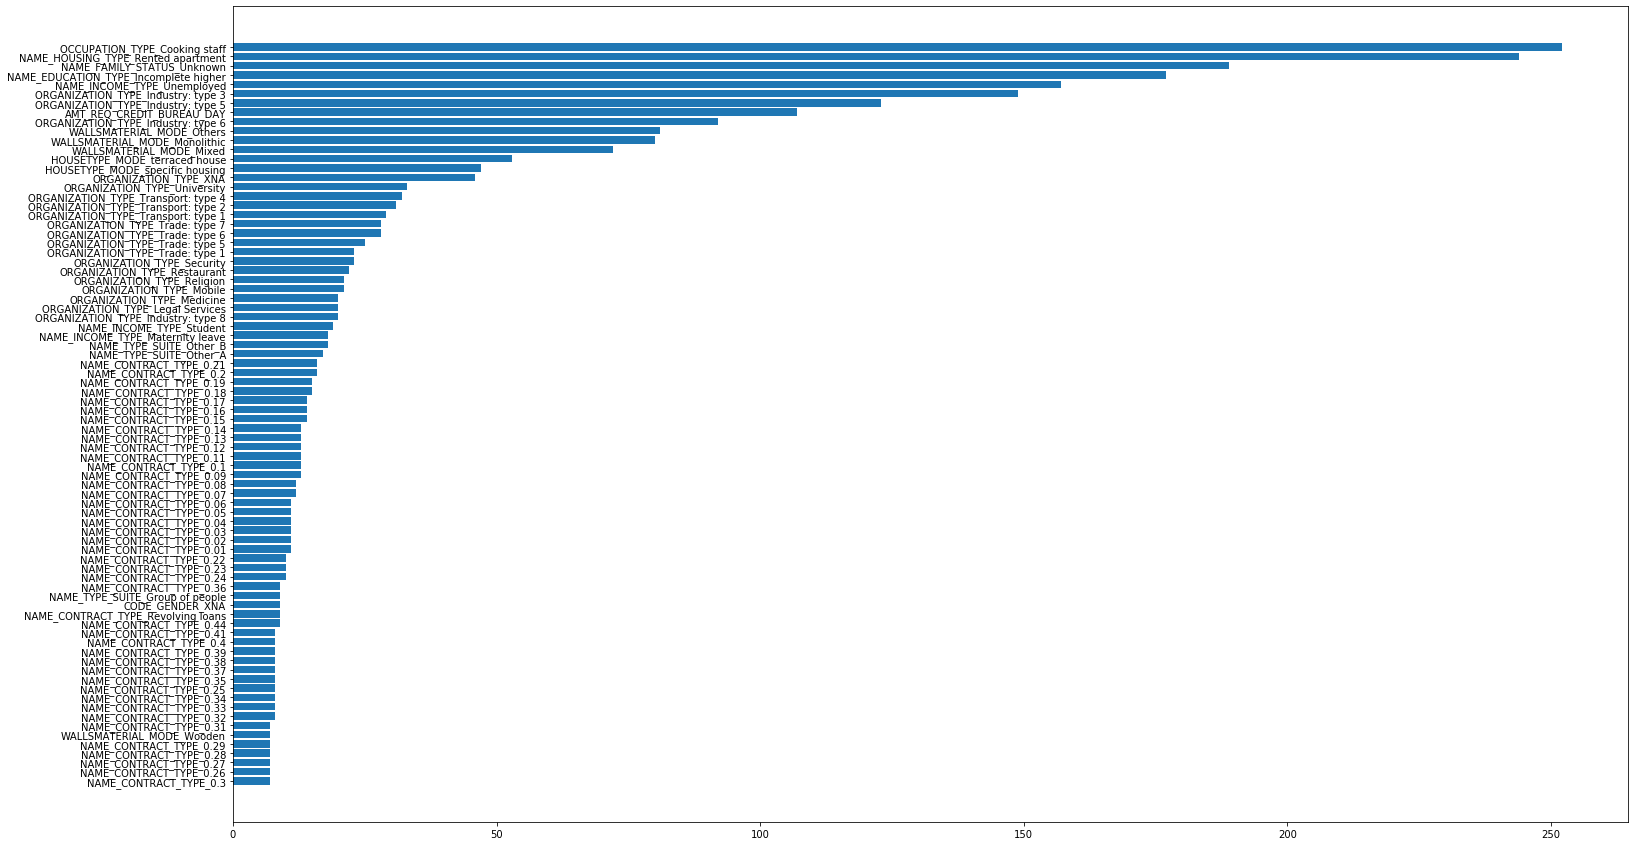

In [233]:
plt.figure(figsize=(25,15))
plt.barh(f_importance_df.index[:80],f_importance_df['importance'].tail(80),align = 'center')

In [234]:
# feature_importancesが０のカラム
f_importance_df[f_importance_df['importance']==0].T

,NAME_CONTRACT_TYPE_0.3,NAME_CONTRACT_TYPE_0.26,NAME_CONTRACT_TYPE_0.27,NAME_CONTRACT_TYPE_0.28,NAME_CONTRACT_TYPE_0.29,WALLSMATERIAL_MODE_Wooden,NAME_CONTRACT_TYPE_0.31,NAME_CONTRACT_TYPE_0.32,NAME_CONTRACT_TYPE_0.33,NAME_CONTRACT_TYPE_0.34,NAME_CONTRACT_TYPE_0.25,NAME_CONTRACT_TYPE_0.35,NAME_CONTRACT_TYPE_0.37,NAME_CONTRACT_TYPE_0.38,NAME_CONTRACT_TYPE_0.39,NAME_CONTRACT_TYPE_0.4,NAME_CONTRACT_TYPE_0.41,NAME_CONTRACT_TYPE_0.44,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_XNA,NAME_TYPE_SUITE_Group of people,NAME_CONTRACT_TYPE_0.36,NAME_CONTRACT_TYPE_0.24,NAME_CONTRACT_TYPE_0.23,NAME_CONTRACT_TYPE_0.22,NAME_CONTRACT_TYPE_0.01,NAME_CONTRACT_TYPE_0.02,NAME_CONTRACT_TYPE_0.03,NAME_CONTRACT_TYPE_0.04,NAME_CONTRACT_TYPE_0.05,NAME_CONTRACT_TYPE_0.06,NAME_CONTRACT_TYPE_0.07,NAME_CONTRACT_TYPE_0.08,NAME_CONTRACT_TYPE_0.09,NAME_CONTRACT_TYPE_0.1,NAME_CONTRACT_TYPE_0.11,NAME_CONTRACT_TYPE_0.12,NAME_CONTRACT_TYPE_0.13,NAME_CONTRACT_TYPE_0.14,NAME_CONTRACT_TYPE_0.15,NAME_CONTRACT_TYPE_0.16,NAME_CONTRACT_TYPE_0.17,NAME_CONTRACT_TYPE_0.18,NAME_CONTRACT_TYPE_0.19,NAME_CONTRACT_TYPE_0.2,NAME_CONTRACT_TYPE_0.21,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Student,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,ORGANIZATION_TYPE_Industry: type 6,AMT_REQ_CREDIT_BUREAU_DAY,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 3,NAME_INCOME_TYPE_Unemployed,NAME_EDUCATION_TYPE_Incomplete higher,NAME_FAMILY_STATUS_Unknown,NAME_HOUSING_TYPE_Rented apartment,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 4,FLAG_DOCUMENT_21,EMERGENCYSTATE_MODE_Yes,FLAG_DOCUMENT_19,FLAG_DOCUMENT_7,ELEVATORS_MEDI,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,REG_REGION_NOT_LIVE_REGION,FLAG_DOCUMENT_12,FLAG_DOCUMENT_4,FLAG_DOCUMENT_20,FLAG_DOCUMENT_2,FLAG_DOCUMENT_17,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_CONT_MOBILE
importance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [235]:
f_importance_df[f_importance_df['importance']==0].size

113

### feature_importancesが10以上の特徴でlightGBM

In [239]:
d_col = f_importance_df[f_importance_df['importance']<=10].index
d_col

Index(['NAME_CONTRACT_TYPE_0.3', 'NAME_CONTRACT_TYPE_0.26',
       'NAME_CONTRACT_TYPE_0.27', 'NAME_CONTRACT_TYPE_0.28',
       'NAME_CONTRACT_TYPE_0.29', 'WALLSMATERIAL_MODE_Wooden',
       'NAME_CONTRACT_TYPE_0.31', 'NAME_CONTRACT_TYPE_0.32',
       'NAME_CONTRACT_TYPE_0.33', 'NAME_CONTRACT_TYPE_0.34',
       ...
       'OBS_60_CNT_SOCIAL_CIRCLE', 'YEARS_BUILD_MODE',
       'WALLSMATERIAL_MODE_Panel', 'LANDAREA_MEDI', 'NONLIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MODE', 'COMMONAREA_MEDI', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_18', 'ENTRANCES_AVG'],
      dtype='object', length=216)

In [240]:
t_t2 = t_t.drop(d_col,axis=1)
# trainとtestに戻す
X2 = t_t2[t_t2['train_test_FLG'] == 0].drop(['train_test_FLG','SK_ID_CURR'],axis=1).values
X_test2 = t_t2[t_t2['train_test_FLG'] == 1].drop(['train_test_FLG','SK_ID_CURR'],axis=1).values
y2 = train_df.TARGET.values
X_train2,X_val2,y_train2,y_val2 = train_test_split(X2,y2,test_size=0.3,random_state=1)

In [241]:
model2 = lgb.LGBMClassifier(objective='binary')
model2.fit(X_train2,y_train2)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

accuracy_score: 0.9185292778632905
precision_score: 0.09259259259259259
recall_score: 0.0027247956403269754
F値: 0.005293806246691371


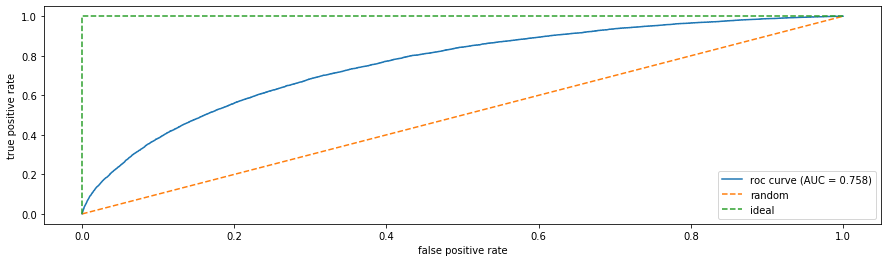

In [242]:
y_pred2 = model2.predict(X_val2)
score_plot(model2,X_val2,y_val2,y_pred2)

AUCが少し下がってしまった．やっぱりlightGBMは特徴量を削らない方がいい...???
### 欠損値の多いカラムは外れ値としてmax+1にする

In [174]:
# 欠損割合の確認
null_train = pd.DataFrame((train_data.isnull().sum() /len(train_data)).sort_values(ascending=False))
null_train.head(50)

,0
COMMONAREA_MODE,0.698723
COMMONAREA_MEDI,0.698723
COMMONAREA_AVG,0.698723
NONLIVINGAPARTMENTS_MEDI,0.694330
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_AVG,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_MEDI,0.683550
LIVINGAPARTMENTS_AVG,0.683550
LIVINGAPARTMENTS_MODE,0.683550


In [176]:
# 欠損割合の確認
null_test = pd.DataFrame((test_data.isnull().sum() /len(test_data)).sort_values(ascending=False))
null_test.head(50)

,0
COMMONAREA_AVG,0.687161
COMMONAREA_MEDI,0.687161
COMMONAREA_MODE,0.687161
NONLIVINGAPARTMENTS_MEDI,0.684125
NONLIVINGAPARTMENTS_AVG,0.684125
NONLIVINGAPARTMENTS_MODE,0.684125
FONDKAPREMONT_MODE,0.672842
LIVINGAPARTMENTS_MODE,0.672493
LIVINGAPARTMENTS_MEDI,0.672493
LIVINGAPARTMENTS_AVG,0.672493


欠損パターンはtrainとtestで似てる．マージしたデータで欠損が50％を超えるカラムのサンプルは外れ値を入れておく．     
ていうか，mode,median,average全部入らない気もする....

In [205]:
null_df = pd.DataFrame(t_t.isnull().sum() /len(t_t),columns=['NULL_PERCENT'])
null_col = null_df[null_df['NULL_PERCENT']>=0.4].index
null_col

Index(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAREA_MEDI', 'TO

In [277]:
t_t.loc[:,null_col].describe(include='all')

,OWN_CAR_AGE,EXT_SOURCE_1,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE
count,121014.000000,162345.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,185200.000000
mean,12.023741,0.501965,0.118138,0.088673,0.977889,0.752283,0.045045,0.079819,0.150015,0.227331,0.232817,0.066454,0.101495,0.108089,0.008868,0.028503,0.114914,0.087750,0.977239,0.759452,0.042930,0.075346,0.145471,0.223315,0.228878,0.065092,0.106382,0.106641,0.008116,0.027183,0.118549,0.088178,0.977903,0.755548,0.044994,0.078930,0.149494,0.226922,0.232504,0.067296,0.102674,0.109279,0.008697,0.028386,0.103193
std,11.880848,0.210045,0.108954,0.082312,0.057929,0.113267,0.077045,0.135249,0.100139,0.145051,0.161909,0.081287,0.093418,0.111194,0.047876,0.069880,0.108745,0.084076,0.063165,0.110112,0.075437,0.133025,0.101088,0.144126,0.161725,0.081911,0.098779,0.112555,0.046330,0.070723,0.109824,0.082017,0.058562,0.112057,0.077140,0.135133,0.100450,0.145453,0.162419,0.082267,0.094541,0.112881,0.047519,0.070574,0.108041
min,0.000000,0.013458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.335503,0.057700,0.044500,0.976700,0.687200,0.007900,0.000000,0.069000,0.166700,0.083300,0.018700,0.050400,0.045800,0.000000,0.000000,0.052500,0.041000,0.976700,0.699400,0.007300,0.000000,0.069000,0.166700,0.083300,0.016600,0.054200,0.043100,0.000000,0.000000,0.058300,0.044100,0.976700,0.691400,0.007900,0.000000,0.069000,0.166700,0.083300,0.018800,0.051300,0.046200,0.000000,0.000000,0.041500
50%,9.000000,0.506155,0.088000,0.076500,0.981600,0.755200,0.021300,0.000000,0.137900,0.166700,0.208300,0.048200,0.075600,0.074900,0.000000,0.003600,0.084000,0.074900,0.981600,0.764800,0.019200,0.000000,0.137900,0.166700,0.208300,0.045900,0.077100,0.073300,0.000000,0.001100,0.087400,0.076100,0.981600,0.758500,0.021000,0.000000,0.137900,0.166700,0.208300,0.048700,0.077000,0.075400,0.000000,0.003100,0.069000
75%,15.000000,0.673344,0.148500,0.112300,0.986600,0.823200,0.051900,0.120000,0.206900,0.333300,0.375000,0.085800,0.121000,0.131000,0.003900,0.027800,0.146000,0.112700,0.986600,0.823600,0.049300,0.120800,0.206900,0.333300,0.375000,0.084300,0.131300,0.125800,0.003900,0.023200,0.149400,0.111800,0.986600,0.825600,0.051800,0.120000,0.206900,0.333300,0.375000,0.087000,0.123100,0.131200,0.003900,0.026800,0.128700
max,91.000000,0.962693,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1

In [305]:
a = t_t[null_col[1:]].fillna(t_t[null_col].max()+1)
t_t.loc[:,null_col[1:]] = a
b = t_t['OWN_CAR_AGE'].fillna(t_t['OWN_CAR_AGE'].max()+10)
t_t.OWN_CAR_AGE = b
t_t.describe(include='all')

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_test_FLG,NAME_CONTRACT_TYPE_0.01,NAME_CONTRACT_TYPE_0.02,NAME_CONTRACT_TYPE_0.03,NAME_CONTRACT_TYPE_0.04,NAME_CONTRACT_TYPE_0.05,NAME_CONTRACT_TYPE_0.06,NAME_CONTRACT_TYPE_0.07,NAME_CONTRACT_TYPE_0.08,NAME_CONTRACT_TYPE_0.09,NAME_CONTRACT_TYPE_0.1,NAME_CONTRACT_TYPE_0.11,NAME_CONTRACT_TYPE_0.12,NAME_CONTRACT_TYPE_0.13,NAME_CONTRACT_TYPE_0.14,NAME_CONTRACT_TYPE_0.15,NAME_CONTRACT_TYPE_0.16,NAME_CONTRACT_TYPE_0.17,NAME_CONTRACT_TYPE_0.18,NAME_CONTRACT_TYPE_0.19,NAME_CONTRACT_TYPE_0.2,NAME_CONTRACT_TYPE_0.21,NAME_CONTRACT_TYPE_0.22,NAME_CONTRACT_TYPE_0.23,NAME_CONTRACT_TYPE_0.24,NAME_CONTRACT_TYPE_0.25,NAME_CONTRACT_TYPE_0.26,NAME_CONTRACT_TYPE_0.27,NAME_CONTRACT_TYPE_0.28,NAME_CONTRACT_TYPE_0.29,NAME_CONTRACT_TYPE_0.3,NAME_CONTRACT_TYPE_0.31,NAME_CONTRACT_TYPE_0.32,NAME_CONTRACT_TYPE_0.33,NAME_CONTRACT_TYPE_0.34,NAME_CONTRACT_TYPE_0.35,NAME_CONTRACT_TYPE_0.36,NAME_CONTRACT_TYPE_0.37,NAME_CONTRACT_TYPE_0.38,NAME_CONTRACT_TYPE_0.39,NAME_CONTRACT_TYPE_0.4,NAME_CONTRACT_TYPE_0.41,NAME_CONTRACT_TYPE_0.44,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,

In [306]:
# trainとtestに戻す
X3 = t_t[t_t['train_test_FLG'] == 0].drop(['train_test_FLG','SK_ID_CURR'],axis=1).values
X_test3 = t_t[t_t['train_test_FLG'] == 1].drop(['train_test_FLG','SK_ID_CURR'],axis=1).values
y3 = train_df.TARGET.values
X_train3,X_val3,y_train3,y_val3 = train_test_split(X3,y3,test_size=0.3,random_state=1)

In [310]:
model3 = lgb.LGBMClassifier(objective='binary',class_weight='balanced')
model3.fit(X_train3,y_train3)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

accuracy_score: 0.6535651570663603
precision_score: 0.07974873685647958
recall_score: 0.3182561307901907
F値: 0.12753876392225377


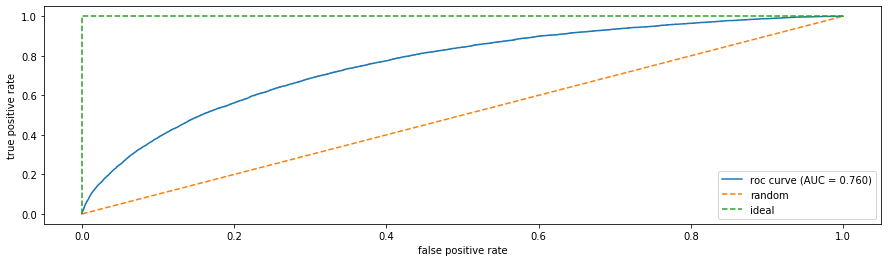

In [311]:
y_pred3 = model3.predict(X_val3)
score_plot(model3,X_val3,y_val3,y_pred3)

AUCは変わらないが，recallとF値が改善した
### 他の欠損値は中央値で埋めて，PCAで次元削減し，lightGBM

In [326]:
new_tt = t_t.fillna(t_t.median())
# trainとtestに戻す
X4 = new_tt[new_tt['train_test_FLG'] == 0].drop(['train_test_FLG','SK_ID_CURR'],axis=1).values
X_test4 = new_tt[new_tt['train_test_FLG'] == 1].drop(['train_test_FLG','SK_ID_CURR'],axis=1).values
y4 = train_df.TARGET.values
X_train4,X_val4,y_train4,y_val4 = train_test_split(X4,y4,test_size=0.3,random_state=1)

In [327]:
sc = StandardScaler()
sc.fit(X_train4)
X_train4 = sc.transform(X_train4)
X_val4 = sc.transform(X_val4)

In [328]:
X_train4.shape

(215257, 271)

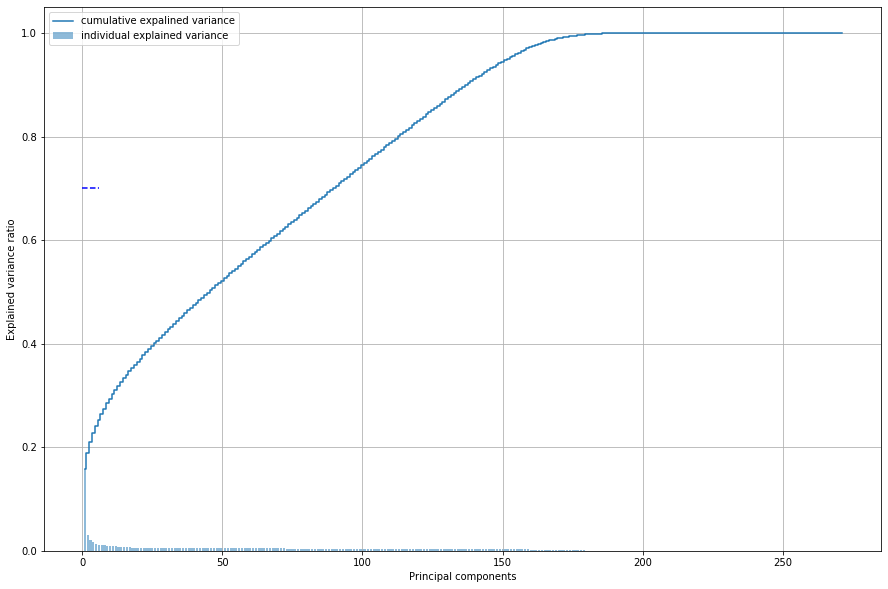

In [329]:
# PCAの分散説明率を表示
pca = PCA(n_components=None)
pca = pca.fit(X_train4)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
#print(cum_var_exp)
plt.figure(figsize=(15,10))
plt.bar(range(1,272), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,272), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

In [330]:
pca = PCA(n_components=120)
pca.fit(X_train4)
X_train4 = pca.transform(X_train4)
X_val4 = pca.transform(X_val4)

In [331]:
model4 = lgb.LGBMClassifier(objective='binary',class_weight='balanced')
model4.fit(X_train4,y_train4)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

accuracy_score: 0.6489799900275327
precision_score: 0.08103857864623415
recall_score: 0.3299727520435967
F値: 0.13012061138421038


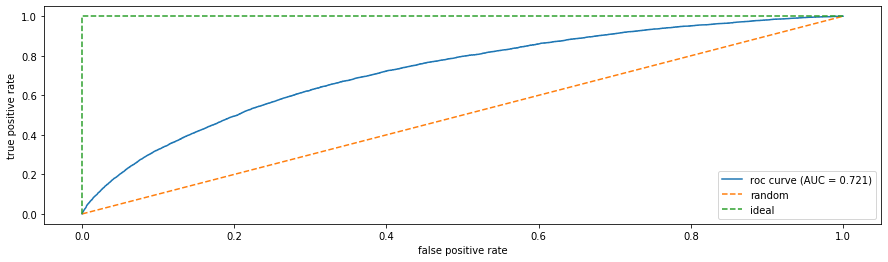

In [332]:
y_pred4 = model4.predict(X_val4)
score_plot(model4,X_val4,y_val4,y_pred4)

次元を圧縮したら，AUCは下がってしまった．